# Palmer Penguins Dataset Analysis
## Machine Learning, Fall 2021
### Name: Michael Hlavaty

# Introduction
In this notebook, I explore a dataset on Palmer Penguins published in 2014 by Dr. Kristen Gorman and the Palmer Station. Then, I build a model to classify one of the penguins based of the series of physical characterstics provided.

Let's start by importing a number of helpful Python libraries and then loading the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns

from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('palmer_penguins/penguins_size.csv')
data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Okay, so it seems that we will be using a number of physical characterstics of a penguin to classify its species. Here are those physical characterstics:
* `island`: the island from where the penguin was found, either Dream, Torgersen, or Biscoe in the Palmer Archipelago (Antarctica),
* `culmen_length_mm`: the length of the penguin's culmen, in millimeters,
* `culmen_depth_mm`: the depth of the penguin's culmen, in millimeters,
* `flipper_length_mm`: the length of the penguin's flipper, in millimeters,
* `body_mass_g`: the mass of the penguin, in grams,
* `sex`: the sex of the penguin, either male or female,
* `species` (__response__): the species of the penguin, either Adelie, Chinstrap, or Gentoo

The goal of this machine learning exercise is to analyze a number of distributions of the data, and then to build a model to classify a penguin based on its physical characteristics.

# Cleaning Data

Based on the table above, I can already see some missing data (`NaN`).

In [3]:
data[data.isnull().any(axis=1)]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


Okay, so I can see 10 penguins with missing values. Since there are more than 300 penguins, I feel comfortable removing the penguins from the dataset rather than removing the columns with the respective missing values. As observed in the table above, all the penguins with missing data also have `NaN` values for `sex`. Thus, I can remove all penguins with missing, or null data in the `sex` column.

In [4]:
data = data[data.sex.notnull()] # removing all observations (penguins) whose sex is null, or NaN
data[data.isnull().any(axis=1)]
data = data.reset_index()

Great! It appears that we removed all `NaN` values from the dataset. However, there may still being missing or unexpected (negative) values. Let's look at some basic statistics for the dataset.

In [5]:
data.describe()

,index,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,334.000000,334.000000,334.000000,334.000000,334.000000
mean,172.793413,43.994311,17.160479,201.014970,4209.056886
std,97.612101,5.460521,1.967909,14.022175,804.836129
min,0.000000,32.100000,13.100000,172.000000,2700.000000
25%,89.250000,39.500000,15.600000,190.000000,3550.000000
50%,172.500000,44.500000,17.300000,197.000000,4050.000000
75%,256.750000,48.575000,18.700000,213.000000,4793.750000
max,343.000000,59.600000,21.500000,231.000000,6300.000000


There are 334 rows in the dataset. The mean `flipper_length_mm` > `culmen_length_mm` > `culmen_depth_mm`, which makes sense because I'd expect a penguin's flipper to be longer than their culmen, and I would expect that the depth of the culmen to be shorter than the length of the culmen and its flipper. There does not appear to be any outliers yet: there are no negative values based on the `min` values and the `min` doesn't appear to significantly deviate from the `25%` percentile, and the `max` values do not appear to be very large relative to the `75%` percentile. The values from this table seem reasonable.

The table only described quantitative data, so let's take a look at `sex`.

In [6]:
data.sex.describe()

count      334
unique       3
top       MALE
freq       168
Name: sex, dtype: object

Okay, not saying that gender is binary, but why are there 3 unique categories for the penguins' `sex`? Let's take a deeper look at the distribution of `sex` using a histogram.

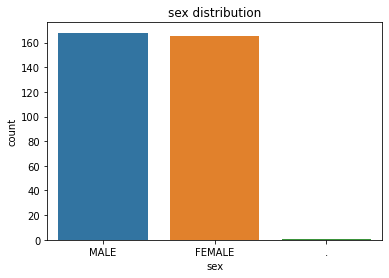

In [7]:
sns.countplot(x='sex',data=data)
plt.title("sex distribution")
plt.show()

Okay, so there appears to be a third gender: ".". The count appears to be very low, perhaps those data might be typos? I will take a deeper look at these data and then I might consider removing them from the dataset.

In [8]:
data[data.sex=="."]

,index,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
327,336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


The other values in this penguin don't appear to deviate much from the respective mean values of the quantitative variables. I think that this is simply a typo, and I will remove the penguin from the dataset.

In [9]:
data = data[data.sex!="."]
data = data.reset_index()

Okay, now that I've analyzed the 5 explanatory variables and found the values to be reasonable, I am going to start graphing the data. 

With that being said, there may still be more missing or incorrect data, but I feel comfortable graphing the data that I have right now.

# Graphs

### Pairplot Colored by `Species`

We can use a seaborn pairplot to plot the four quantitative explanatory variables (`culmen_length_mm`, `culmen_depth_mm`, `flipper_length_mm`, `body_mass_g`) against one another and color them by a qualitative variable (`sex`, `island`, `species`). Since we are trying to classify the penguins by their `species`, I'm going to color the data by `Species`.

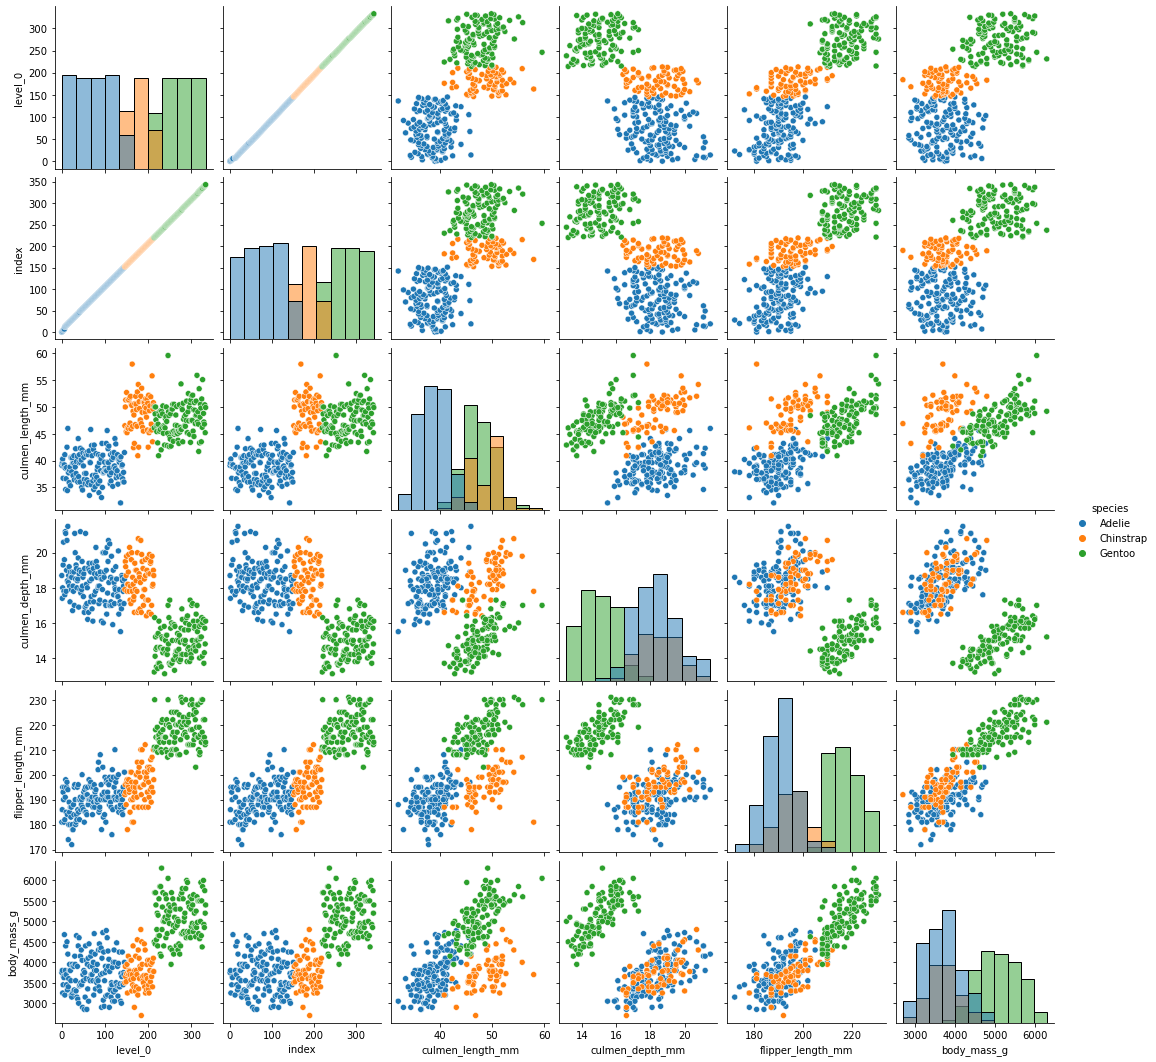

In [10]:
sns.pairplot(data, hue="species", diag_kind="hist")
plt.show()

After taking a look at the graphs from a visual standpoint, one thing I wonder is why there are so many diagonal patterns? For example, the greater x-axis values most of the time correspond to a greater y-axis values. This is probably because the larger physical characterstics likely correspond to a larger penguin, meaning that the penguin overall has larger physical characterstics. These seemingly linear correlations can be modeled by using a linear regression line. There's a lot going on in the pairplot above, and so for the graphs that I take a deeper look at, I'll likely consider the linear regression lines for each species.

I wonder, how much does the `hue='species'` parameter affect the interpretation of the dataset? In other words, what does coloring the data by `species` tell us?

##### Coloring by `culmen_length_mm`

One variable that I want to take a deeper look at is the `culmen_length_mm` variable. When any of the other three quantitative factors are graphed by `culmen_length_mm`, as seen on the leftmost column in the pairplot, there appear to be three relatively distinct clusters.

Let's start by first analyzing what the graphs of `culmen_depth_mm`, `flipper_length_mm`, and `body_mass_g` look like when they are not graphed against `culmen_length_mm`. We can do this by using a seaborn stripplot.

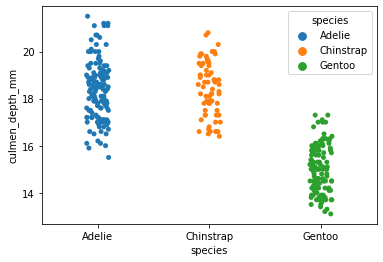

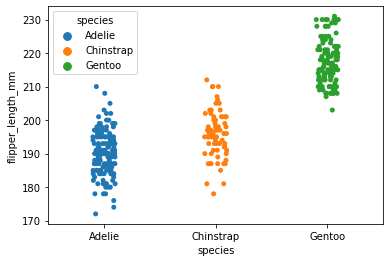

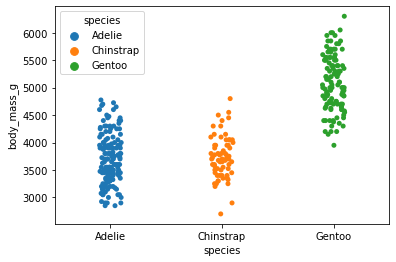

In [11]:
sns.stripplot(x="species", y="culmen_depth_mm", hue="species", data=data)
plt.show()

sns.stripplot(x="species", y="flipper_length_mm", hue="species", data=data)
plt.show()

sns.stripplot(x="species", y="body_mass_g", hue="species", data=data)
plt.show()

There appears to be a lot of overlap between Adelie and Chinstrap penguins in terms of their `culmen_depth_mm`, `flipper_length_mm`, and `body_mass_g` and a little bit of overlap with that of the Gentoo penguins. Therefore, it may be hard to classify a penguin solely based on those variables. 

Now, let's take a look at the graphs when you plot those variables with respect to `culmen_length_mm`.

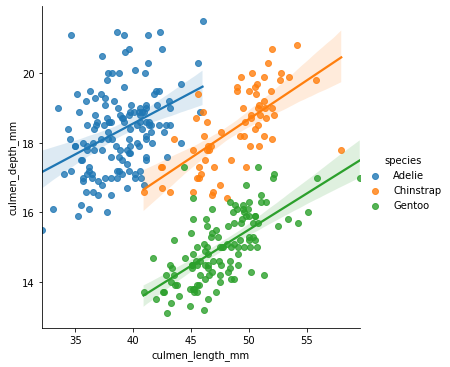

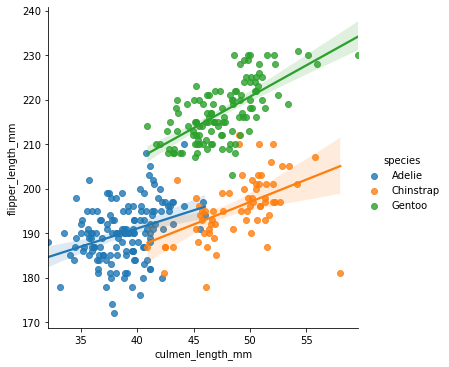

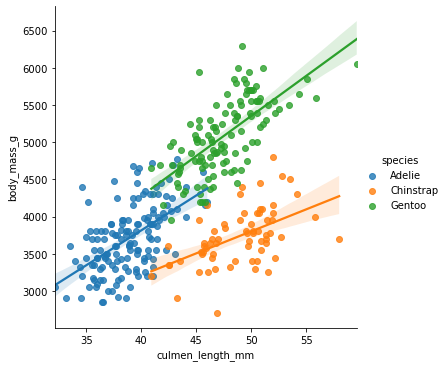

In [12]:
# Code inspired by https://seaborn.pydata.org/examples/multiple_regression.html
sns.lmplot(
    data=data,
    x="culmen_length_mm", y="culmen_depth_mm", hue="species",
    height=5
)
sns.lmplot(
    data=data,
    x="culmen_length_mm", y="flipper_length_mm", hue="species",
    height=5
)
sns.lmplot(
    data=data,
    x="culmen_length_mm", y="body_mass_g", hue="species",
    height=5
)
plt.show()

By plotting `culmen_depth_mm`, `flipper_length_mm`, and `body_mass_g` by `culmen_length_mm`, I can see three clusters in the dataset, and they are all distinguished by `species`. The positive, relatively strongly correlated linear regression lines helped me come to the following conclusions:

* It appears that penguins with a higher `culmen_length_mm` and lower `culmen_depth_mm` are likely Gentoo penguins, penguins with a higher `culmen_length_mm` and higher `culmen_depth_mm` are likely Chinstrap penguins, and penguins with a lower `culmen_length_mm` and higher `culmen_depth_mm` are likely Adelie penguins.
* It appears that penguins with a lower `culmen_length_mm` and `flipper_length_mm` are likely Adelie penguins, penguins with a higher `culmen_length_mm` and lower `flipper_length_mm` are likely Chinstrap penguins, and penguins with a higher `culmen_length_mm` and `flipper_length_mm` are likely Gentoo penguins.
* It appears that penguins with a lower `culmen_length_mm` and `body_mass_g` are likely Adelie penguins, penguins with a higher `culmen_length_mm` and lower `body_mass_g` are likely Chinstrap penguins, and penguins with a higher `culmen_length_mm` and `body_mass_g` are likely Gentoo penguins. 

The "and" is particularly important, because it uses the comparison of two explanatory variables to help distinguish a penguin's `species`.

##### Chinstrap and Adelie overlap, Gentoo distinction

To revisit the point on grpahing the data without `culmen_length_mm`, there is a lot of overlap between the physical characterstics of Chinstrap and Adelie penguins, and the Gentoo penguins are relatively separate from the other species. For example, when graphing `culmen_depth_mm` by `flipper_length_mm` and `body_mass_g`, there is a very clear distinction between Gentoo penguins and the other two penguins.

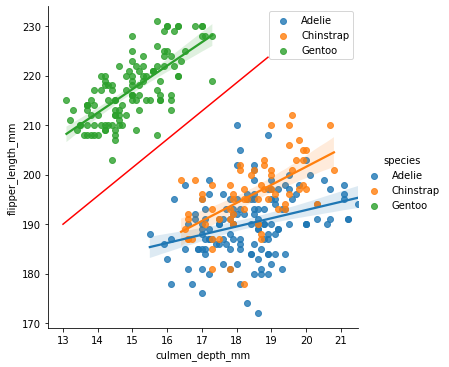

In [13]:
sns.lmplot(
    data=data,
    x="culmen_depth_mm", y="flipper_length_mm", hue="species",
    height=5
)
x=np.arange(13,19,0.1)
y=(40/7)*x+115.7
sns.lineplot(x=x,y=y,color="red")
plt.show()

The red line acts as a visual divider between the Gentoo penguins from the Adelie and Chinstrap penguins. Based on the graph, any penguin with a culmen depth < 17mm and flipper length > 203mm is likely a Gentoo penguin.

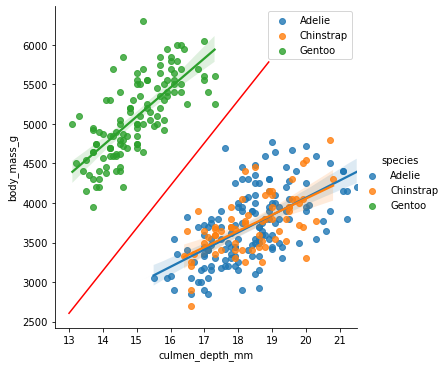

In [14]:
sns.lmplot(
    data=data,
    x="culmen_depth_mm", y="body_mass_g", hue="species",
    height=5
)
x=np.arange(13,19,0.1)
y=((6000-2500)/(19.5-13))*x-4394
sns.lineplot(x=x,y=y,color="red")
plt.show()

Once again, the red line acts as a visual aid to help distinguish the Gentoo penguins from the Adelie and Chinstrap penguins. It appears that any penguin with a body mass > 4000g and a culmen depth < 17mm is probably a Gentoo penguin. In the graph above, there is a lot of overlap betwen the Adelie and Chinstrap penguins. In fact, the linear regression lines also have a relatively similar slope and closely follow each other.

By looking at the two graphs above, classifying data without considering `culmen_length_mm` will be very difficult. For example, Adelie and Chinstrap penguins have very similar distributions, and it will be hard to distinguish the penguins from each other. On the other hand, classifying Gentoo penguins by analyzing `culmen_depth_mm` by `body_mass_g` and `culmen_depth_mm` by `flipper_length_mm` will likely be very helpful because their distributions are very distinct from the other species, as seen in the graphs and red lines above.

### `island` Histograms

One of the categorical variables I might want to consider is the island from which the penguins are from. We can analyze the distribution of species of penguins on each island using a histogram.

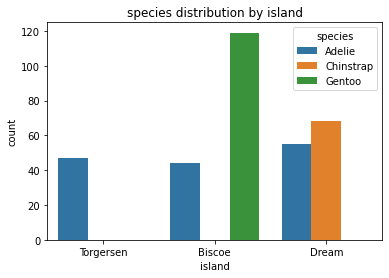

In [15]:
sns.countplot(x='island', hue='species',data=data)
plt.title("species distribution by island")
plt.show()

It appears that Adelie penguins are from all three islands, and they are the only penguins from Torgersen island. Gentoo penguins are only from Biscoe island, and Chinstrap penguins are only from Dream island. I think that island will be an especially distinguishing parameter in the classifier because there is very little overlap.

### `sex` Histograms

The other categorical variable that I may want to consider is the penguin's sex. I can first take a look at the distribution of penguin's sex amongst species and island. Maybe there are only male Chinstrap penguins in this dataset, so all female penguins could not be Chinstraps?

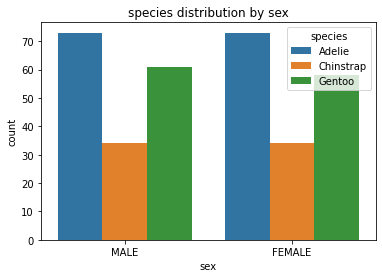

In [16]:
sns.countplot(x='sex',hue='species',data=data)
plt.title("species distribution by sex")
plt.show()

It appears that the `sex` distributions are relatively equal for the three `species`. So, to answer my question above, `sex` does not automatically classify a penguin into or from a species.

Even though it does not automatically classify a penguin into or from a species, I wonder, how might it help distinguish penguins by species?

I can plot the distributions of the physical characteristics of a penguin and group the distributions by species and color the points by sex, and this might reveal some helpful patterns.

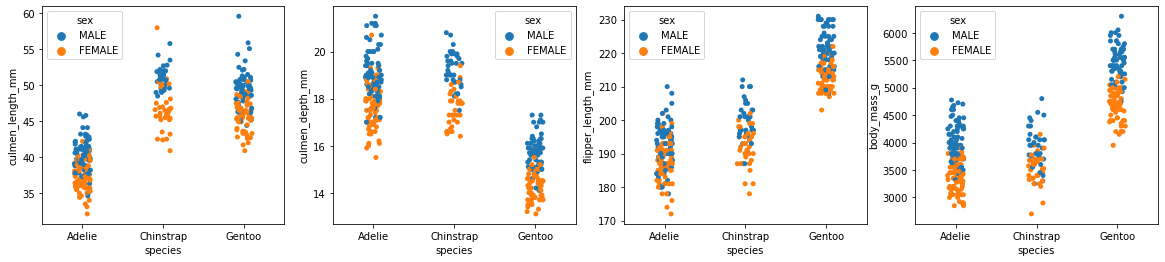

In [17]:
fig = plt.figure()
fig.set_size_inches(20, 4)
# code snippet inspiration taken from https://stackoverflow.com/questions/56788245/is-there-a-restriction-on-catplot-with-subplot, https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
ax1 = fig.add_subplot(141)
g = sns.stripplot(x="species", y="culmen_length_mm", hue="sex", data=data, ax=ax1) # pass ax1
ax2 = fig.add_subplot(142)
g = sns.stripplot(x="species", y="culmen_depth_mm", hue="sex", data=data, ax=ax2) # pass ax2
ax3 = fig.add_subplot(143)
g = sns.stripplot(x="species", y="flipper_length_mm", hue="sex", data=data, ax=ax3) # pass ax3
ax4 = fig.add_subplot(144)
g = sns.stripplot(x="species", y="body_mass_g", hue="sex", data=data, ax=ax4) # pass ax4

plt.close(2)
plt.close(3)

plt.show()

Okay, so I can see one pattern that is consistent throughout all four plots: female penguins typically have smaller physical characterstics than those of the male penguins of the same species. With that being said, there is a lot of overlap between the male and female physical characterstics. For example, the distribution of `flipper_length_mm` for Adelie penguins is almost completely overlapping for male and female penguins. Similarly, the distributions of male and female Chinstrap penguins' `body_mass_g` are very overlapping. There are a couple distributions that are a little more distinguishing, such as `body_mass_g` for Gentoo penguins. With that being said, within each species, there is still a lot of overlap for the distributions of male and female physical characteristics.

After looking at the histogram for the distribution of `sex` within each species and seaborn stripplots for the penguins' physical characteristics colored by sex above, I don't think that `sex` will be a particularly distinguishing factor when trying to classify the penguins to a species.

# `Species` Classifier

Now, I'm going to try and build a model that will classify a penguin's `species`. I will use the following explanatory variables to do so:
* `island` (categorical)
* `culmen_length_mm` (numerical)
* `culmen_depth_mm` (numerical)
* `flipper_length_mm` (numerical)
* `body_mass_g` (numerical)

In [18]:
biscoe, dream, torg = np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data))
for i in range(len(data)):
    if data.loc[i].island == "Biscoe":
        biscoe[i] = 1
    elif data.loc[i].island == "Dream":
        dream[i] = 1
    else:
        torg[i] = 1
data['biscoe'],data['dream'],data['torgersen'] = biscoe,dream,torg

adelie, chinstrap, gentoo, s2 = np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data))
for i in range(len(data)):
    if data.loc[i].species == "Adelie":
        adelie[i] = 1
        s2[i]=0
    elif data.loc[i].species == "Chinstrap":
        chinstrap[i] = 1
        s2[i]=1
    else:
        gentoo[i] = 1
        s2[i]=2
data['adelie'],data['chinstrap'],data['gentoo'],data['s2'] = adelie, chinstrap, gentoo,s2

In [19]:
data.drop('species', axis=1, inplace=True)
data.drop('island', axis=1, inplace=True)
data.drop('sex', axis=1, inplace=True)

In [213]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.20)

In [214]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', max_iter=1000)

x_train = train.drop('s2',1)
y_train = train.s2
model.fit(x_train,y_train)

LogisticRegression(max_iter=1000)

In [215]:
x_test = test.drop('s2',1)
y_pred = model.predict(x_test)
accuracy_arr = test.s2.tolist()-y_pred
print(accuracy_arr)
incorrect = 0
for i in accuracy_arr:
    if i != 0:
        incorrect += 1
print("Accuracy ({} Samples): {}%".format(len(accuracy_arr),100-100*(incorrect/len(accuracy_arr))))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy (67 Samples): 100.0%


Okay, so it seems that this is a relatively easy dataset to classify.